# Capstone 2 Modeling Notebook

0. | [Intro](#0.Intro)
1. | [Review Data](#1.Review_Data)
2. | [Model Selection #1 (high-lvl)](#2.Model_Selection)
3. | [Bayes_Deep-Dive](#3.Bayes_Deep-Dive)
4. | [Other Methods](#4.Other_Methods)
5. | [Model Selection #2 (decision)](#5.Model_Selection)
6. | [AirBnB-Data](#6.Abnb_Data)
7. | [Outcome](#7.Final_Outcome)


# 0.Intro
- Objective: Train model on Hotel Dataset and use to predict airbnb scores in order to determine whether there is a discrepancy between Airbnb scores and their associated reviews
- Secondary Objective: Deep dive into sentiment analysis modeling using real data to determine what model and parameters allow for optimizing sentiment
- Tertiary Objectives: Utilize modules for more concise/pithy main notebook codebase


#### Scores to Optimize
- As the purpose is to find both an accurate but also aggregate representation of a corpus of docs, I use the following three metrics to evaluate models by...
- fdf

________________________________________
##### 1. Accuracy (total correct predictions / total predictions)
##### 2. Distribution Accuracy (total per class predictions / total per class labels)
##### 3. Error Accuracy (measure of % of total predictions within 1 class of correct class or in otherwords that are correct or off by one score)

In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from functions import sample_mean
from lists import stop_words,noise
from plots import model_plots
import string
import warnings
import os


%matplotlib inline
punctuation = set(string.punctuation)
sws = stop_words().get_sws()
noise = noise().get_noise()


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',500)

listings = pd.read_pickle('~/Notebooks/data/listings.pickle')
# reviews = pd.read_pickle('~/Desktop/g.school/data/reviews.pickle')
hotels = pd.read_pickle('data/hotels.pickle')

hotels = pd.read_pickle('data/hotels.pickle')
hotels = hotels.drop('reviews.id',axis=1)[hotels['language']=='en']
hotels['reviews.rating'] = hotels['reviews.rating'].replace(1.0,2.0).replace(0.0,2.0)


## 1.Review_Data
0. | [Top](#0.Intro)


- Show that classes in hotel training data are not evenly distributed

32288


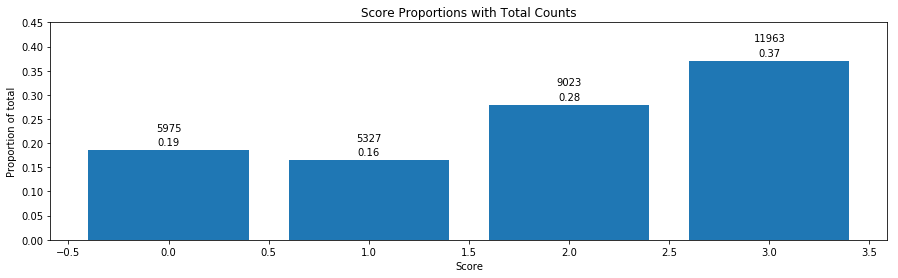

In [233]:
text_sample_pct = 3/3
np.random.seed(8)

# bad_examples = hotels.iloc[noise][['reviews.text','reviews.rating']]
hotel_text = hotels[['clean_text','reviews.rating','reviews.text','word_count']].sample(frac=(text_sample_pct))\
                                                    .reset_index()\
                                                    .drop('index',axis=1)
# noise_mask = ~hotel_text.index.isin(noise)
# hotel_text = hotel_text[noise_mask]
hotel_text = hotel_text.reset_index().drop('index',axis=1)

plt.figure(figsize=(15,4))
hotel_text['reviews.rating'] = hotel_text['reviews.rating'].astype(int).replace(0,1)
hotel_text['reviews.text'] = [' '.join([word.lower() for word in sent.split()\
                                        if word not in punctuation]) for sent in hotel_text['reviews.text']]
score_counts = hotel_text['reviews.rating'].value_counts().sort_index()
review_distribution = score_counts/score_counts.sum()
hotel_text['reviews.rating'].value_counts()

plt.bar(range(review_distribution.shape[0]),review_distribution.sort_index().values)
for i,v in enumerate(review_distribution.sort_index().values):
    plt.text(i,v+.01,round(v,2),horizontalalignment='center')
    plt.text(i,v+.04,score_counts.iloc[i],horizontalalignment='center')
plt.title('Score Proportions with Total Counts')
plt.xlabel('Score')
plt.ylabel('Proportion of total')

plt.ylim(0,.45)
print(hotel_text.shape[0])
hotel_text.head()
hotel_text['clean_text']
pd.set_option('max_colwidth', 200)

# 2.Model_Selection
0. | [Top](#0.Intro)


- Decided to try both symbolic and stochastic models beginning with the symbolic (rule-based) VaderSentiment score
- Try Naive Bayes, Random Forest, Gradient Boost. Naive Bayes proves most robust after first round of model building
## VADER_Sentiment_Score

In [234]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sa = SentimentIntensityAnalyzer()
hotel_vader = pd.DataFrame([sa.polarity_scores(review) for review in hotel_text['clean_text']])
hotel_text = hotel_text.join(hotel_vader)
hotel_text['vader_rating'] = ((hotel_text['compound']+1)/(1/2.5)).apply(np.round).astype(int).replace(0,2).replace(1,2)

### Binary Positive Negative Score Counts

Vader Training Accuracy 0.458
Vader Accuracy 0.458
Vader Distribution Accuracy 0.78
Vader Error Accuracy 0.0

 [[3174  736 1400  665]
 [1292  600 1720 1715]
 [ 917  545 2761 4800]
 [ 638  327 2754 8244]] 

              precision    recall  f1-score   support

           2       0.53      0.53      0.53      5975
           3       0.27      0.11      0.16      5327
           4       0.32      0.31      0.31      9023
           5       0.53      0.69      0.60     11963

   micro avg       0.46      0.46      0.46     32288
   macro avg       0.41      0.41      0.40     32288
weighted avg       0.43      0.46      0.43     32288



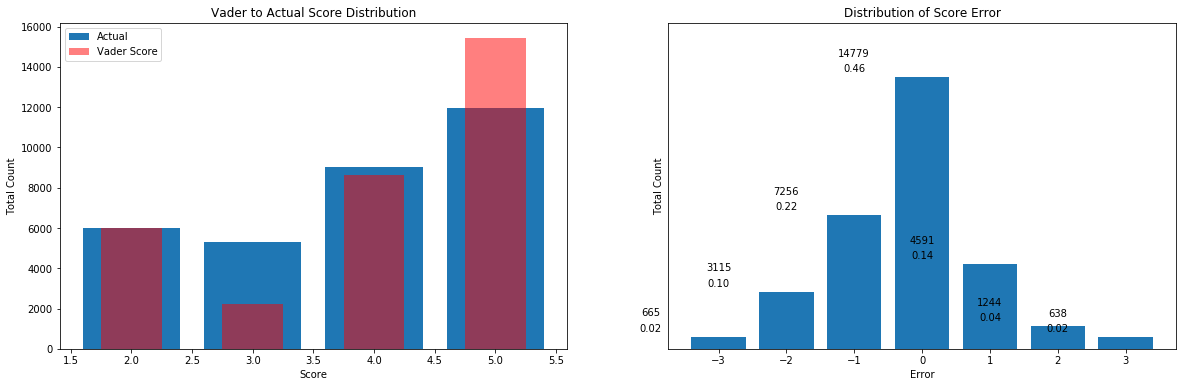

In [235]:
hotel_text['pos/neg'] = hotel_text['compound'] > 0
vader_plots = model_plots()

vader_plots.model_to_actual_plot(hotel_text,hotel_text['reviews.rating'],
                                 hotel_text['vader_rating'],
                                 'Actual',
                                 'Vader Score',
                                 'Vader to Actual Score Distribution')
vader_plots.error_plot(hotel_text,hotel_text['reviews.rating'],
                       hotel_text['vader_rating'],
                       'Error',
                       'total count')

accuracy_vader = hotel_text['vader_rating'].eq(hotel_text['reviews.rating']).mean().round(3)
vader_test = hotel_text['vader_rating'].value_counts()
vader_pred = hotel_text['reviews.rating'].value_counts()
distribution_error_vader = (vader_pred.sub(vader_test).abs().sum()/vader_test.sum()).round(2)
error_accuracy_vader = vader_pred.sub(vader_test).abs().lt(2).mean()
training_accuracy_vader = accuracy_vader

print('Vader Training Accuracy',accuracy_vader)
print('Vader Accuracy',accuracy_vader)
print('Vader Distribution Accuracy',1-distribution_error_vader)
print('Vader Error Accuracy',error_accuracy_vader.round(3))
print('\n',confusion_matrix(hotel_text['reviews.rating'],hotel_text['vader_rating']),'\n')
print(classification_report(hotel_text['reviews.rating'],hotel_text['vader_rating']))

## Naive_Bayes

#### Attempting Stratified K-Folds

In [27]:
# from sklearn.model_selection import StratifiedKFold
# skf = StratifiedKFold(random_state=0,n_splits=3,shuffle=False)
# for train_idx,test_idx in skf.split(x_train,y_train):
#     print('Train_index: ',train_idx,'Test_index: ',test_idx)
#     x_train[train_idx],x_train[test_idx]
#     y_train[train_idx],y_train[test_idx]

Using BOW increases model accuracy by 7%. tfidf together with bayes seems to have been biased against classes with low frequency. with BOW I'm now pulling in multiple

Bayes Training Accuracy 0.68
Bayes Accuracy 0.567
Bayes Distribution Accuracy 0.854
Bayes Error Accuracy 0.899


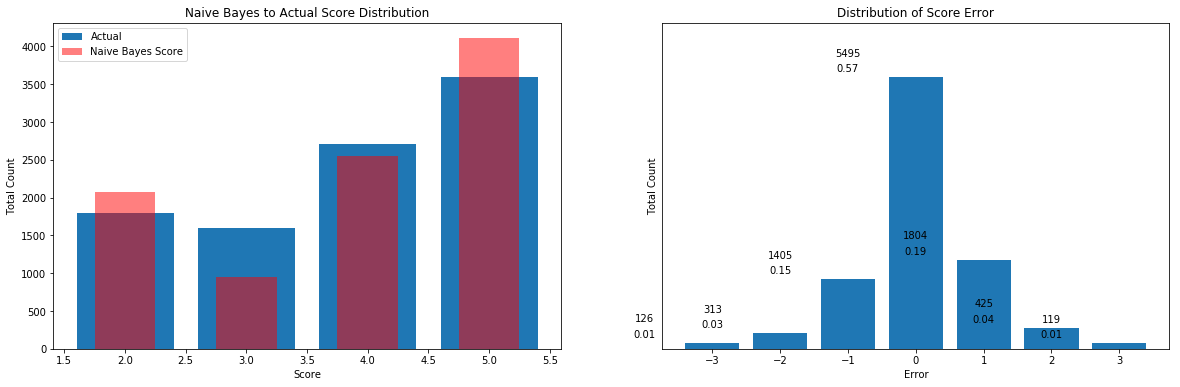

In [236]:
from sklearn.naive_bayes import MultinomialNB
X = hotel_text['reviews.text']
y = hotel_text['reviews.rating']
count = CountVectorizer(stop_words='english')
tfidf = TfidfVectorizer(stop_words='english')
X = count.fit_transform(X)
x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=3,stratify=y,test_size=.30)


nb = MultinomialNB()
nb.fit(x_train,y_train)
ypred = pd.Series(nb.predict(x_test),index=y_test.index)
ypred_train = nb.predict(x_train)
nb_plots = model_plots()


nb_plots.model_to_actual_plot(hotel_text,
                              y_test,
                              ypred,
                              'Actual',
                              'Naive Bayes Score',
                              'Naive Bayes to Actual Score Distribution')
nb_plots.error_plot(hotel_text,ypred,y_test,'Error','total count')


accuracy_bayes = (ypred == y_test).mean().round(3)
distribution_error_bayes = (ypred.sub(y_test).abs().sum()/y_test.sum()).round(3)
error_accuracy_bayes = ((y_test.sub(ypred)).lt(2) & (y_test.sub(ypred)).gt(-2)).mean().round(3)
training_accuracy_bayes = round((ypred_train - y_train).value_counts().max()/(ypred_train - y_train).value_counts().sum(),2)

print('Bayes Training Accuracy',training_accuracy_bayes)
print('Bayes Accuracy',accuracy_bayes)
print('Bayes Distribution Accuracy',1-distribution_error_bayes)
print('Bayes Error Accuracy',error_accuracy_bayes.round(3))

## Random_Forest

Training Accuracy 0.97
RF Accuracy 0.505
RF Distribution Accuracy 0.8220000000000001
RF Error Accuracy 0.854


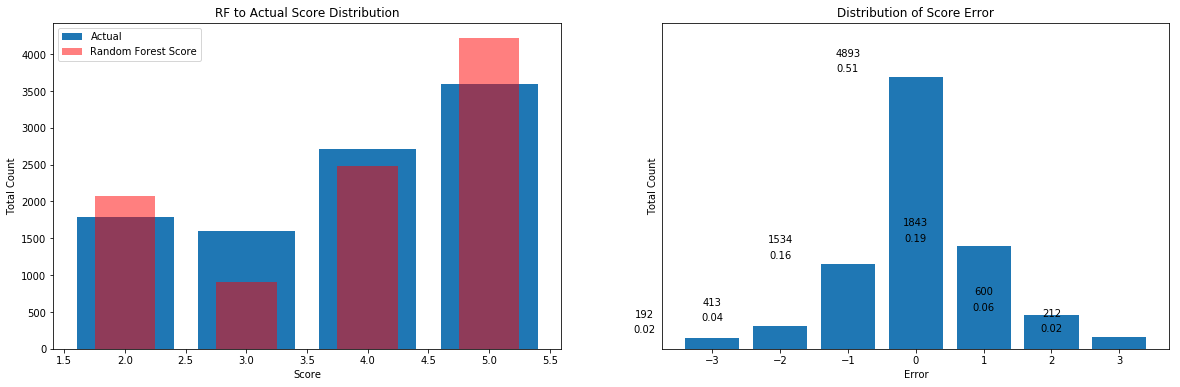

In [240]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=3)

X = hotel_text['reviews.text']
y = hotel_text['reviews.rating']
count = CountVectorizer(stop_words=sws,ngram_range=(1,1))
tfidf = TfidfVectorizer(stop_words=sws)
X = tfidf.fit_transform(X).toarray()
x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=3,stratify=y,test_size=.30)


rf.fit(x_train,y_train)
ypred = pd.Series(rf.predict(x_test),index=y_test.index)
ypred_train = rf.predict(x_train)
# print('Test Set: \n',(ypred - y_test).value_counts()/(ypred - y_test).value_counts().sum())
rf_plots = model_plots()


rf_plots.model_to_actual_plot(hotel_text,
                              y_test,
                              ypred,
                              'Actual',
                              'Random Forest Score',
                              'RF to Actual Score Distribution')
rf_plots.error_plot(hotel_text,ypred,y_test,'Error','total count')


accuracy_rf = (ypred == y_test).mean().round(3)
distribution_error_rf = (ypred.sub(y_test).abs().sum()/y_test.sum()).round(3)
error_accuracy_rf = ((y_test.sub(ypred)).lt(2) & (y_test.sub(ypred)).gt(-2)).mean().round(3)


print('Training Accuracy',round((ypred_train - y_train).value_counts().max()/(ypred_train - y_train).value_counts().sum(),2))
print('RF Accuracy',accuracy_rf)
print('RF Distribution Accuracy',1-distribution_error_rf)
print('RF Error Accuracy',error_accuracy_rf.round(3))

In [40]:
# training_accuracy_rf = round((ypred_train - y_train).value_counts().max()/(ypred_train - y_train).value_counts().sum(),2)
training_accuracy_rf = 0.97

Decrease overfitting by increasing max_depth... I know it doesn't make sense

In [241]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=3,max_depth = 40)
rf.fit(x_train,y_train)

ypred = rf.predict(x_test)
ypred_test = rf.predict(x_train)
print('Test Set: \n',(ypred - y_test).value_counts().max()/(ypred - y_test).value_counts().sum())
print('Training Set: \n',(ypred_test - y_train).value_counts().max()/(ypred_test - y_train).value_counts().sum())

Test Set: 
 0.4937545163621348
Training Set: 
 0.7339498252289721


### Gradient_Boost

In [81]:
# from sklearn.ensemble import GradientBoostingClassifier

# X = hotel_text['reviews.text']
# y = hotel_text['reviews.rating']
# count = CountVectorizer(stop_words=sws,ngram_range=(1,1))
# tfidf = TfidfVectorizer(stop_words=sws)
# X = tfidf.fit_transform(X).toarray()

# x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=3,stratify=y,test_size=.30)

# gb = GradientBoostingClassifier(random_state=3)
# gb.fit(x_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=3,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [82]:
ypred = gb.predict(x_test)
ypred_test = gb.predict(x_train)
print('Test Set: \n',(ypred - y_test).value_counts()/(ypred - y_test).value_counts().sum())
print('Training Set: \n',(ypred_test - y_train).value_counts()/(ypred_test - y_train).value_counts().sum())

Test Set: 
  0    0.472652
 1    0.231682
-1    0.113003
 2    0.095459
 3    0.043344
 4    0.024252
-2    0.013416
-3    0.004128
-4    0.002064
Name: reviews.rating, dtype: float64
Training Set: 
  0    0.701991
 1    0.139823
 2    0.067478
-1    0.042920
 3    0.026327
 4    0.015265
-2    0.004646
-3    0.000885
-4    0.000664
Name: reviews.rating, dtype: float64


# 3.Bayes_Deep-Dive
0. | [Top](#0.Intro)


- Why: Bayes proves most robust in first pass of model building. Here I delve deeper into Bayes and try GaussianNB, Multinomial, ComplementNB as well as MultinomialNB with custom stop-words list and without stopwords entirely
- Top Score: Multinomial Bayes set to default laplace smoothing = 1. Of all bayes classifiers, this is most robust with accuracy of .54 and error accuracy of .88 in comparison to a train score of .67 indicating overfitting but not as much as seen with other models
- Parameter Tuning: applied updates to stop_words, remove punctuation, tfidf and count vectorization, different nb models as well as ngrams of 1,2 and 3 sizes. N_grams greater than 1 overfit. Laplace smoothing default is optimal

## GaussianNB

Test:  0.2776917518323526
Train:  0.5360824742268041


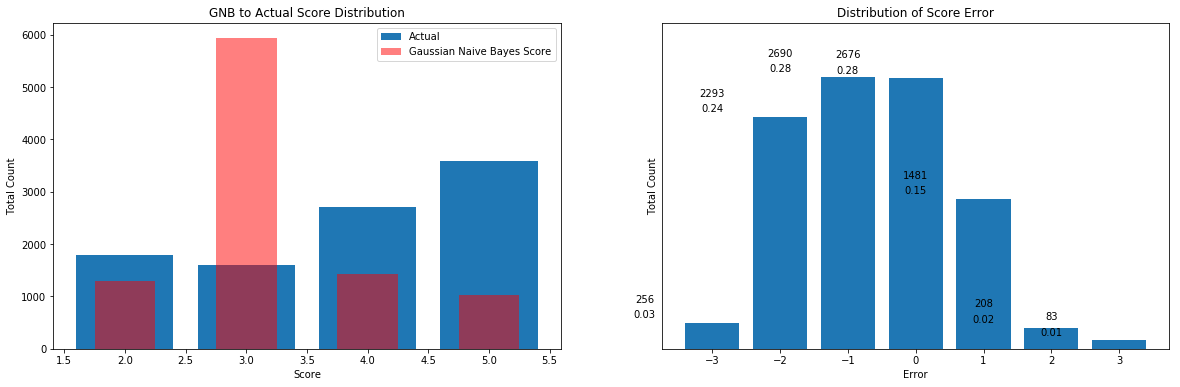

In [242]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

X = hotel_text['reviews.text']
y = hotel_text['reviews.rating']
count = CountVectorizer(stop_words='english')
tfidf = TfidfVectorizer(stop_words='english')
X = count.fit_transform(X).toarray()
x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=3,stratify=y,test_size=.30)

nb.fit(x_train,y_train)
ypred = pd.Series(nb.predict(x_test),index=y_test.index)
ypred_test = nb.predict(x_train)
print('Test: ',(ypred - y_test).value_counts().max()/(ypred - y_test).value_counts().sum())
print('Train: ',(ypred_test - y_train).value_counts().max()/(ypred_test - y_train).value_counts().sum())


gnb_plots = model_plots()


gnb_plots.model_to_actual_plot(hotel_text,
                              y_test,
                              ypred,
                              'Actual',
                              'Gaussian Naive Bayes Score',
                              'GNB to Actual Score Distribution')
gnb_plots.error_plot(hotel_text,ypred,y_test,'Error','total count')

## Complement_Naive_Bayes

Training Accuracy 0.67
cnb Accuracy 0.551
cnb Distribution Accuracy 0.836
cnb Error Accuracy 0.86


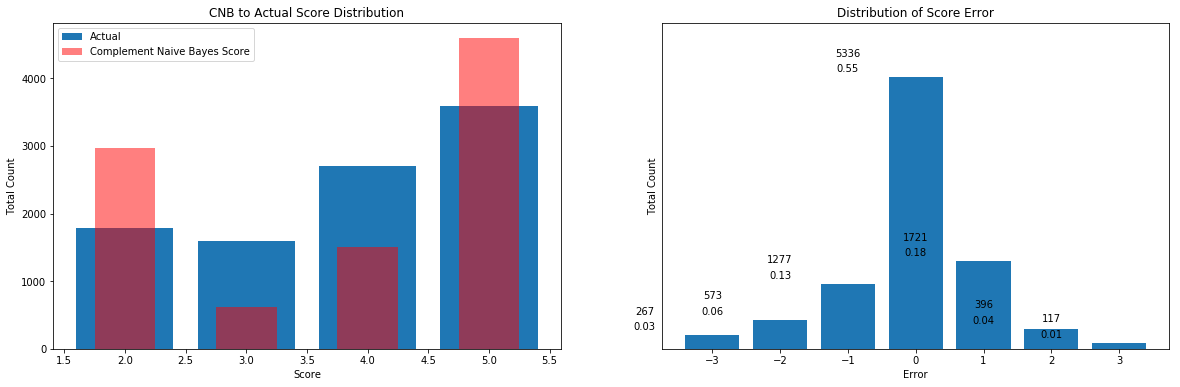

In [243]:
from sklearn.naive_bayes import ComplementNB
nb = ComplementNB()

X = hotel_text['reviews.text']
y = hotel_text['reviews.rating']
count = CountVectorizer(stop_words='english')
tfidf = TfidfVectorizer(stop_words='english')
X = count.fit_transform(X).toarray()
x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=3,stratify=y,test_size=.30)

nb.fit(x_train,y_train)
ypred = pd.Series(nb.predict(x_test),index=y_test.index)
ypred_train = nb.predict(x_train)
# print('Test: ',(ypred - y_test).value_counts().max()/(ypred - y_test).value_counts().sum())
# print('Train: ',(ypred_test - y_train).value_counts().max()/(ypred_test - y_train).value_counts().sum())
cnb_plots = model_plots()


cnb_plots.model_to_actual_plot(hotel_text,
                              y_test,
                              ypred,
                              'Actual',
                              'Complement Naive Bayes Score',
                              'CNB to Actual Score Distribution')
cnb_plots.error_plot(hotel_text,ypred,y_test,'Error','total count')

accuracy_cnb = (ypred == y_test).mean().round(3)
distribution_error_cnb = (ypred.sub(y_test).abs().sum()/y_test.sum()).round(3)
error_accuracy_cnb = ((y_test.sub(ypred)).lt(2) & (y_test.sub(ypred)).gt(-2)).mean().round(3)
training_accuracy_cnb = round((ypred_train - y_train).value_counts().max()/(ypred_train - y_train).value_counts().sum(),2)

print('Training Accuracy',round((ypred_train - y_train).value_counts().max()/(ypred_train - y_train).value_counts().sum(),2))
print('cnb Accuracy',accuracy_cnb)
print('cnb Distribution Accuracy',1-distribution_error_cnb)
print('cnb Error Accuracy',error_accuracy_cnb.round(3))

## Multinomial_Naive_Bayes

Training Accuracy 0.68
mnb Accuracy 0.582
mnb Distribution Accuracy 0.86
mnb Error Accuracy 0.905


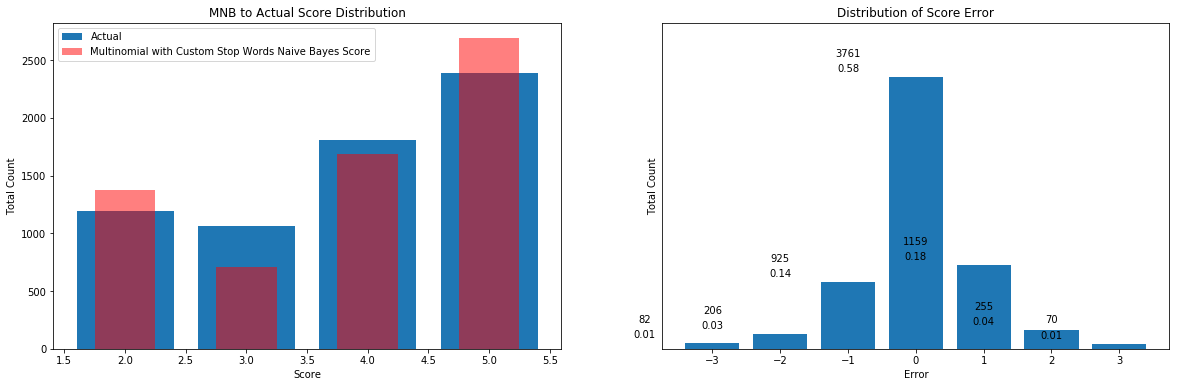

In [244]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

X = hotel_text['reviews.text']
y = hotel_text['reviews.rating']
count = CountVectorizer(stop_words=sws,ngram_range=(1,1))
tfidf = TfidfVectorizer(stop_words=sws)
X = count.fit_transform(X).toarray()
x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=3,stratify=y,test_size=.20)

nb = MultinomialNB()
nb.fit(x_train,y_train)
ypred = pd.Series(nb.predict(x_test),index=y_test.index)
ypred_train = nb.predict(x_train)
# print('Test: ',(ypred - y_test).value_counts().max()/(ypred - y_test).value_counts().sum())
# print('Train: ',(ypred_test - y_train).value_counts().max()/(ypred_test - y_train).value_counts().sum())
mnb_plots = model_plots()


mnb_plots.model_to_actual_plot(hotel_text,
                              y_test,
                              ypred,
                              'Actual',
                              'Multinomial with Custom Stop Words Naive Bayes Score',
                              'MNB to Actual Score Distribution')
mnb_plots.error_plot(hotel_text,ypred,y_test,'Error','total count')

accuracy_mnb = (ypred == y_test).mean().round(3)
distribution_error_mnb = (ypred.sub(y_test).abs().sum()/y_test.sum()).round(3)
error_accuracy_mnb = ((y_test.sub(ypred)).lt(2) & (y_test.sub(ypred)).gt(-2)).mean().round(3)
training_accuracy_mnb = round((ypred_train - y_train).value_counts().max()/(ypred_train - y_train).value_counts().sum(),2)

print('Training Accuracy',training_accuracy_mnb)
print('mnb Accuracy',accuracy_mnb)
print('mnb Distribution Accuracy',1-distribution_error_mnb)
print('mnb Error Accuracy',error_accuracy_mnb.round(3))

In [245]:
print(classification_report(ypred,y_test))

              precision    recall  f1-score   support

           2       0.74      0.64      0.69      1374
           3       0.27      0.40      0.32       709
           4       0.45      0.48      0.46      1684
           5       0.75      0.67      0.70      2691

   micro avg       0.58      0.58      0.58      6458
   macro avg       0.55      0.55      0.54      6458
weighted avg       0.61      0.58      0.60      6458



In [246]:
laplace = [.1,.5,1,2,5,10]
for a in laplace:
    nb = MultinomialNB(alpha=a)
    nb.fit(x_train,y_train)
    ypred = pd.Series(nb.predict(x_test),index=y_test.index)
    ypred_train = nb.predict(x_train)
    
    accuracy_mnb = (ypred == y_test).mean().round(3)
    distribution_error_mnb = (ypred.sub(y_test).abs().sum()/y_test.sum()).round(3)
    error_accuracy_mnb = ((y_test.sub(ypred)).lt(2) & (y_test.sub(ypred)).gt(-2)).mean().round(3)
    training_accuracy_mnb = round((ypred_train - y_train).value_counts().max()/(ypred_train - y_train).value_counts().sum(),2)

    print(f'Training Accuracy_{a}',training_accuracy_mnb)
    print(f'mnb Accuracy_{a}',accuracy_mnb)
    print(f'mnb Distribution Accuracy_{a}',1-distribution_error_mnb)
    print(f'mnb Error Accuracy_{a}',error_accuracy_mnb.round(3))
    print()

Training Accuracy_0.1 0.72
mnb Accuracy_0.1 0.568
mnb Distribution Accuracy_0.1 0.857
mnb Error Accuracy_0.1 0.907

Training Accuracy_0.5 0.7
mnb Accuracy_0.5 0.575
mnb Distribution Accuracy_0.5 0.859
mnb Error Accuracy_0.5 0.907

Training Accuracy_1 0.68
mnb Accuracy_1 0.582
mnb Distribution Accuracy_1 0.86
mnb Error Accuracy_1 0.905

Training Accuracy_2 0.66
mnb Accuracy_2 0.584
mnb Distribution Accuracy_2 0.859
mnb Error Accuracy_2 0.902

Training Accuracy_5 0.61
mnb Accuracy_5 0.57
mnb Distribution Accuracy_5 0.851
mnb Error Accuracy_5 0.886

Training Accuracy_10 0.58
mnb Accuracy_10 0.55
mnb Distribution Accuracy_10 0.839
mnb Error Accuracy_10 0.868



### N-grams show extreme overfitting when compared to results of 1 gram bows

Test:  0.5030959752321982
Train:  0.970353982300885


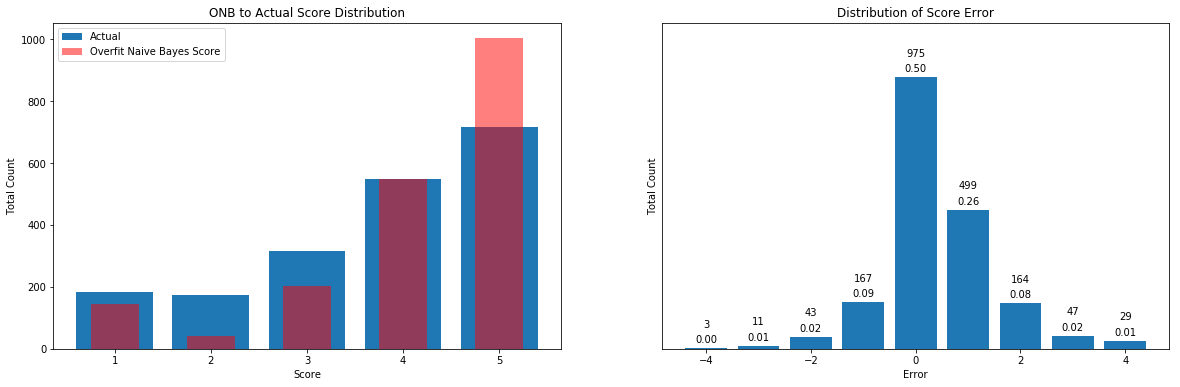

In [18]:
# from sklearn.naive_bayes import MultinomialNB
# nb = MultinomialNB()

# X = hotel_text['reviews.text']
# y = hotel_text['reviews.rating']
# count = CountVectorizer(stop_words='english',ngram_range=(1,3))
# tfidf = TfidfVectorizer(stop_words='english')
# X = count.fit_transform(X).toarray()

# x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=3,stratify=y,test_size=.30)

# nb.fit(x_train,y_train)
# ypred = pd.Series(nb.predict(x_test),index=y_test.index)
# ypred_test = nb.predict(x_train)
# print('Test: ',(ypred - y_test).value_counts().max()/(ypred - y_test).value_counts().sum())
# print('Train: ',(ypred_test - y_train).value_counts().max()/(ypred_test - y_train).value_counts().sum())
# onb_plots = model_plots()


# onb_plots.model_to_actual_plot(hotel_text,
#                               y_test,
#                               ypred,
#                               'Actual',
#                               'Overfit Naive Bayes Score',
#                               'ONB to Actual Score Distribution')
# onb_plots.error_plot(hotel_text,ypred,y_test,'Error','total count')

## No_Stop_words

Training Accuracy 0.68
mnb_no Accuracy 0.575
mnb_no Distribution Accuracy 0.857
mnb_no Error Accuracy 0.9


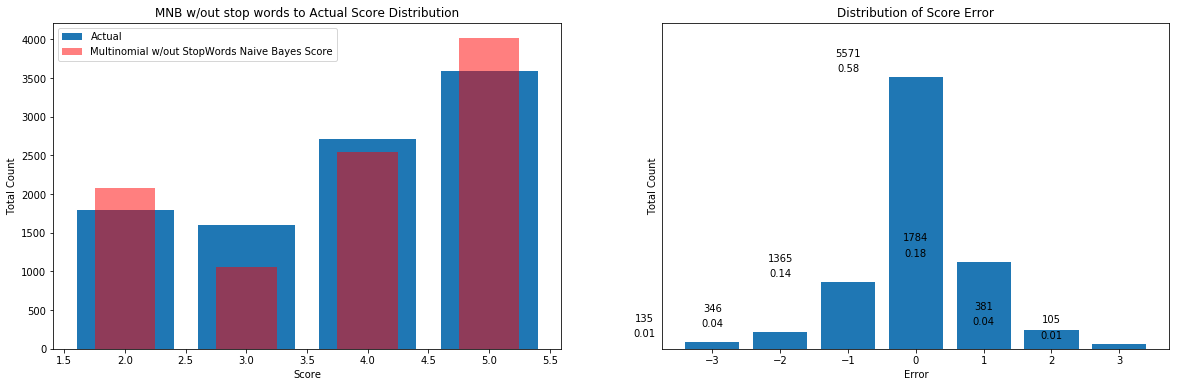

In [247]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

X = hotel_text['reviews.text']
y = hotel_text['reviews.rating']
count = CountVectorizer(stop_words=None,ngram_range=(1,1))
tfidf = TfidfVectorizer(stop_words='english')
X = count.fit_transform(X).toarray()
x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=3,stratify=y,test_size=.30)

nb.fit(x_train,y_train)
ypred = pd.Series(nb.predict(x_test),index=y_test.index)
ypred_train = nb.predict(x_train)
# print('Test: ',(ypred - y_test).value_counts().max()/(ypred - y_test).value_counts().sum())
# print('Train: ',(ypred_test - y_train).value_counts().max()/(ypred_test - y_train).value_counts().sum())
no_sws_nb_plots = model_plots()


no_sws_nb_plots.model_to_actual_plot(hotel_text,
                              y_test,
                              ypred,
                              'Actual',
                              'Multinomial w/out StopWords Naive Bayes Score',
                              'MNB w/out stop words to Actual Score Distribution')
no_sws_nb_plots.error_plot(hotel_text,ypred,y_test,'Error','total count')

accuracy_mnb_no = (ypred == y_test).mean().round(3)
distribution_error_mnb_no = (ypred.sub(y_test).abs().sum()/y_test.sum()).round(3)
error_accuracy_mnb_no = ((y_test.sub(ypred)).lt(2) & (y_test.sub(ypred)).gt(-2)).mean().round(3)
training_accuracy_mnb_no = round((ypred_train - y_train).value_counts().max()/(ypred_train - y_train).value_counts().sum(),2)

print('Training Accuracy',training_accuracy_mnb_no)
print('mnb_no Accuracy',accuracy_mnb_no)
print('mnb_no Distribution Accuracy',1-distribution_error_mnb_no)
print('mnb_no Error Accuracy',error_accuracy_mnb_no.round(3))

# 4.Other_Methods
0. | [Top](#0.Intro)

- Overview: at recommendation by Flora I test alternative simpler logreg and logreg with svd
- Outcome: both are effective in reaching .5. Therefore tune n_components parameter to find optimal n_components
- topic_model tuning: 400 n_components seems to optimize svd

## Logistic Regression

Training Accuracy 0.7
lr Accuracy 0.584
lr Distribution Accuracy 0.861
lr Error Accuracy 0.906


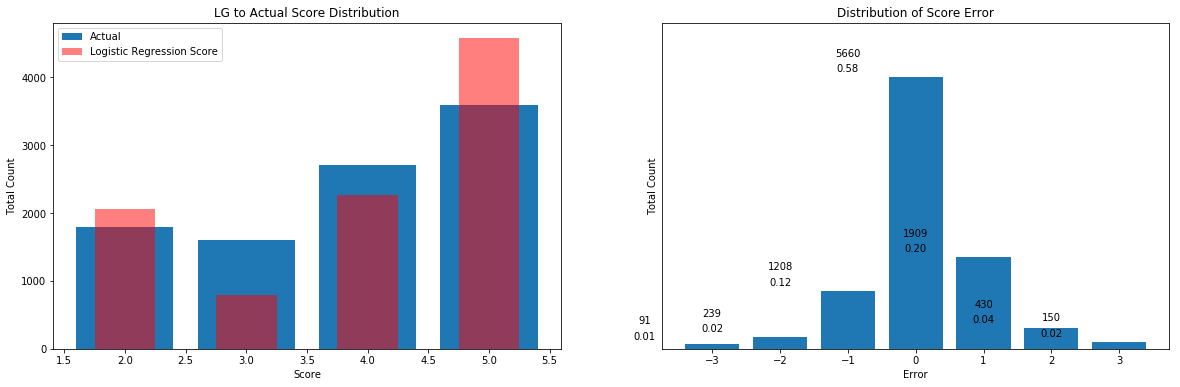

In [248]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=2)


X = hotel_text['reviews.text']
y = hotel_text['reviews.rating']
count = CountVectorizer(stop_words=sws,ngram_range=(1,1))
tfidf = TfidfVectorizer(stop_words=sws)
X = tfidf.fit_transform(X).toarray()

x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=3,stratify=y,test_size=.30)

lr.fit(x_train,y_train)
ypred = pd.Series(lr.predict(x_test),index=y_test.index)
ypred_train = lr.predict(x_train)
# print('Test: ',(ypred - y_test).value_counts().max()/(ypred - y_test).value_counts().sum())
# print('Train: ',(ypred_test - y_train).value_counts().max()/(ypred_test - y_train).value_counts().sum())
lg_plots = model_plots()


lg_plots.model_to_actual_plot(hotel_text,
                              y_test,
                              ypred,
                              'Actual',
                              'Logistic Regression Score',
                              'LG to Actual Score Distribution')
lg_plots.error_plot(hotel_text,ypred,y_test,'Error','total count')

accuracy_lr = (ypred == y_test).mean().round(3)
distribution_error_lr = (ypred.sub(y_test).abs().sum()/y_test.sum()).round(3)
error_accuracy_lr = ((y_test.sub(ypred)).lt(2) & (y_test.sub(ypred)).gt(-2)).mean().round(3)
training_accuracy_lr = round((ypred_train - y_train).value_counts().max()/(ypred_train - y_train).value_counts().sum(),2)

print('Training Accuracy',training_accuracy_lr)
print('lr Accuracy',accuracy_lr)
print('lr Distribution Accuracy',1-distribution_error_lr)
print('lr Error Accuracy',error_accuracy_lr.round(3))

## Topic_Models_SVD

- LSA Topic Model

svdlr Training Accuracy 0.58
svdlr Accuracy 0.562
svdlr Distribution Accuracy 0.846
svdlr Error Accuracy 0.883


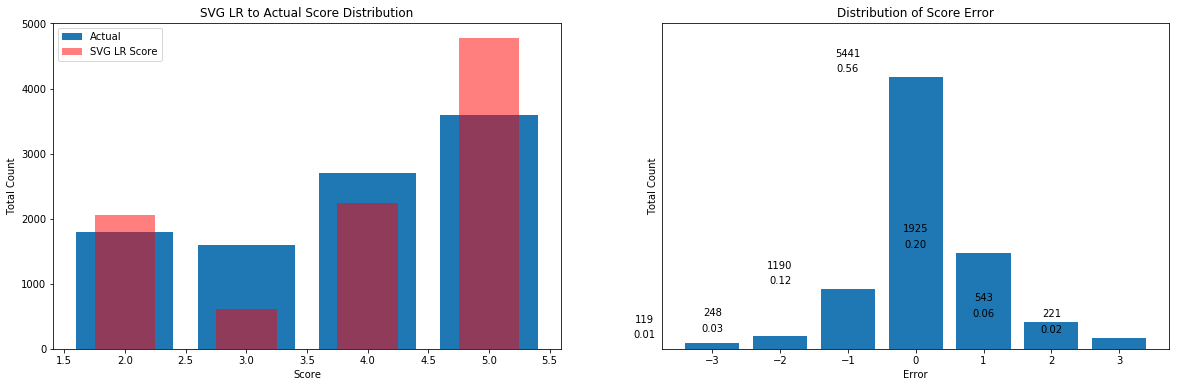

In [249]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LogisticRegression


X = hotel_text['reviews.text']
y = hotel_text['reviews.rating']

count = CountVectorizer(stop_words='english')
tfidf = TfidfVectorizer(stop_words='english')
# X = tfidf.fit_transform(X).toarray()
X = tfidf.fit_transform(X).toarray()




svd = TruncatedSVD(n_components=400,random_state=0,n_iter=1)
svd_topics_vectors = svd.fit_transform(X)
# X = np.c_[svd_topics_vectors,hotel_text['word_count']]
#X = StandardScaler().fit_transform(svd_topics_vectors)


x_train,x_test,y_train,y_test = train_test_split(svd_topics_vectors,y,stratify=y,test_size=.30)


lr = LogisticRegression(random_state=3)
lr.fit(x_train,y_train)

ypred = pd.Series(lr.predict(x_test),index=y_test.index)
ypred_train = lr.predict(x_train)
# print('Test: ',(ypred - y_test).value_counts().max()/(ypred - y_test).value_counts().sum())
# print('Train: ',(ypred_test - y_train).value_counts().max()/(ypred_test - y_train).value_counts().sum())
lr_plots = model_plots()


lr_plots.model_to_actual_plot(hotel_text,
                              y_test,
                              ypred,
                              'Actual',
                              'SVG LR Score',
                              'SVG LR to Actual Score Distribution')
lr_plots.error_plot(hotel_text,ypred,y_test,'Error','total count')

accuracy_svdlr = (ypred == y_test).mean().round(3)
distribution_error_svdlr = (ypred.sub(y_test).abs().sum()/y_test.sum()).round(3)
error_accuracy_svdlr = ((y_test.sub(ypred)).lt(2) & (y_test.sub(ypred)).gt(-2)).mean().round(3)
training_accuracy_svdlr = round((ypred_train - y_train).value_counts().max()/(ypred_train - y_train).value_counts().sum(),2)

print('svdlr Training Accuracy',training_accuracy_svdlr)
print('svdlr Accuracy',accuracy_svdlr)
print('svdlr Distribution Accuracy',1-distribution_error_svdlr)
print('svdlr Error Accuracy',error_accuracy_svdlr.round(3))

## Iterating_with_LR_Topic_Model

In [250]:
X = hotel_text['reviews.text']
y = hotel_text['reviews.rating']

count = CountVectorizer(stop_words='english')
tfidf = TfidfVectorizer(stop_words='english')
# X = tfidf.fit_transform(X).toarray()
X = tfidf.fit_transform(X).toarray()
# X = StandardScaler().fit_transform(X)



def func(r):
    train_y = []
    test_y = []
    for i in r:
        svd = TruncatedSVD(n_components=i,random_state=0,n_iter=1)
        svd_topics_vectors = svd.fit_transform(X)

        x_train,x_test,y_train,y_test = train_test_split(svd_topics_vectors,y,stratify=y,test_size=.30)


        lr = LogisticRegression(random_state=3)
        lr.fit(x_train,y_train)

        ypred = pd.Series(lr.predict(x_test),index=y_test.index)
        ypred_test = lr.predict(x_train)
        print(f'{i}_test: ',(ypred - y_test).value_counts().max()/(ypred - y_test).value_counts().sum())
        print(f'{i}_train: ',(ypred_test - y_train).value_counts().max()/(ypred_test - y_train).value_counts().sum())
        
        test_y.append((ypred - y_test).value_counts().max()/(ypred - y_test).value_counts().sum())
        train_y.append((ypred_test - y_train).value_counts().max()/(ypred_test - y_train).value_counts().sum())
    return train_y,test_y


In [23]:
[2**i for i in range(2,11)]

[4, 8, 16, 32, 64, 128, 256, 512, 1024]

In [251]:
train,test = func([2**i for i in range(2,11)])


4_test:  0.4501909775988438
4_train:  0.44307773992301225
8_test:  0.46959843088675546
8_train:  0.4693597628423521
16_test:  0.49654175699390934
16_train:  0.4908189903101633
32_test:  0.5046970166202126
32_train:  0.5112163178620415
64_test:  0.5226592340249819
64_train:  0.5347108535020574
128_test:  0.548467017652524
128_train:  0.5529843812220698
256_test:  0.5536285743780324
256_train:  0.5788681916729348
512_test:  0.5649839991741509
512_train:  0.5909473032166719
1024_test:  0.5631258387529678
1024_train:  0.6121853015353302


0.5631258387529678

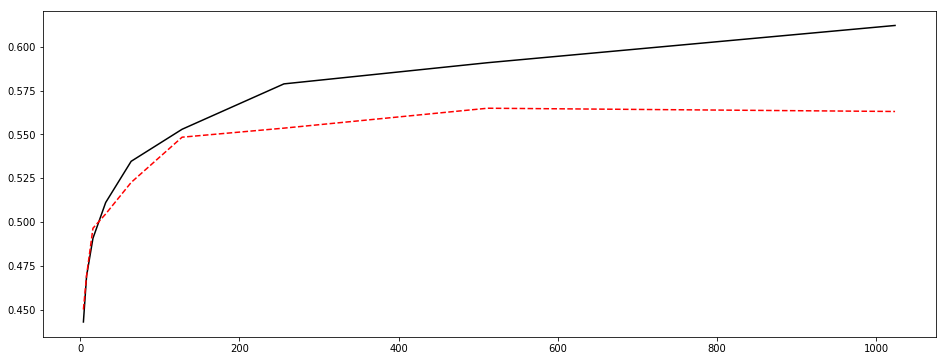

In [252]:
plt.figure(figsize=(16,6))
plt.plot([2**i for i in range(2,11)],train,'k-')
plt.plot([2**i for i in range(2,11)],test,'r--')

test[-1]

In [253]:
np.arange(100,1000,100)
train2,test2 = func(np.arange(100,1000,100))

100_test:  0.5469185506348715
100_train:  0.5460377859386752
200_test:  0.5500154846701766
200_train:  0.5669218176186894
300_test:  0.5597192113141324
300_train:  0.5759922127339498
400_test:  0.5592030556415815
400_train:  0.5840449537631078
500_test:  0.5573448952203984
500_train:  0.5915224990044688
600_test:  0.5635387632910086
600_train:  0.5947524445820981
700_test:  0.5678744709404356
700_train:  0.6018317773549843
800_test:  0.5743780324145762
800_train:  0.5993097650546436
900_test:  0.5645710746361102
900_train:  0.6085128976593956


0.5631258387529678

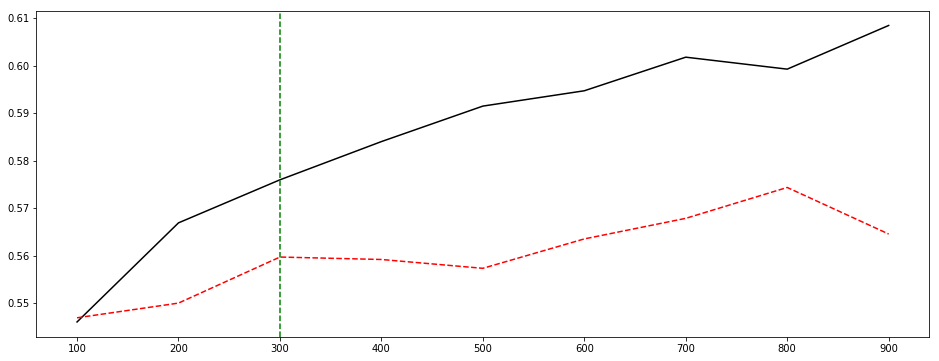

In [255]:
plt.figure(figsize=(16,6))
plt.plot(np.arange(100,1000,100),train2,'k-')
plt.plot(np.arange(100,1000,100),test2,'r--')
plt.axvline(300,color='green',linestyle='--')

test[-1]

Vectors must be non-negative to be used with Bayes

## Work to clean up noisy data (incorrectly labeled data)
- despite clear examples of data being dirt, after removing 56 rows of the most extreme examples, model's results don't seem to budge. It'd be interesting if this process could somehow be automated. 

In [257]:
# from sklearn.linear_model import LogisticRegression
# lr = LogisticRegression(random_state=5)

# X = hotel_text['reviews.text']
# y = hotel_text['reviews.rating']
# count = CountVectorizer(stop_words=sws,ngram_range=(1,1))
# tfidf = TfidfVectorizer(stop_words=sws)
# X = tfidf.fit_transform(X).toarray()
# x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=3,stratify=y,test_size=.30)
# lr.fit(x_train,y_train)
# ypred = pd.Series(lr.predict(x_test),index=y_test.index)


# [y_test.sub(ypred).abs() > 2]
# error_df = hotel_text.iloc[y_test.sub(ypred).abs().gt(1).index][['reviews.text','reviews.rating']]
# mask = y_test.sub(ypred).abs().gt(1)
# error_df = error_df[mask]
# # error_df['prediction'] = 
# error_df['prediction'] = ypred[mask]
# error_df = error_df[error_df['prediction']==5]
# error_df = error_df[error_df['reviews.rating']==1]
# error_df

In [603]:
noise = [5341,6540,8748,2507,4510,5309,5670,5820,10163,5917,8902,3263,25525,12937,25785,700,
         15703,29148,13801,12956,23269,32224,23524,7595,3388,3261,9986,10248,8932,4,8334,
         7656,9980,2748,10134,7652,5063,2940,540,3091,3734,9303,9796,9082,6038,527,8551,8449,
         446,6122,7483,1634,9695,8678,3903,2745]

# 5.Model_Selection
0. | [Top](#0.Intro)


- Overview: Collect all four scoring metrics including training accuracy and plot against each other to find optimal model
- Result: The optimal model turns out to be A multinomial Naive Bayes trained on customized stop_words and a simple BOW vectorizer. This has model has both the highest accuracy distribution accuracy and error accuracy

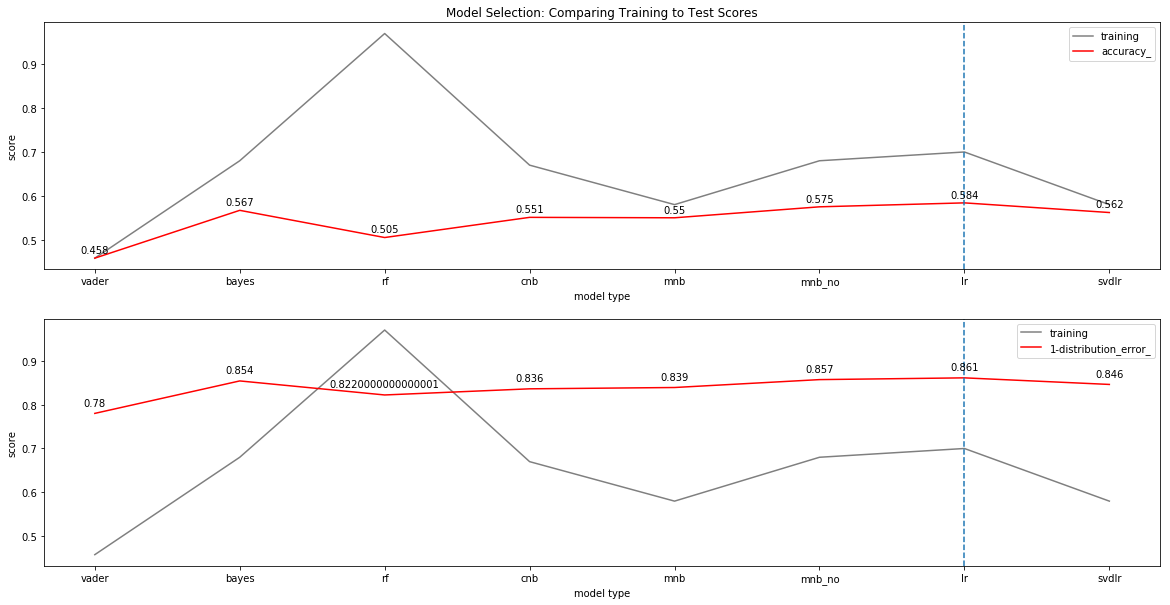

In [258]:
metrics = ['training_accuracy_','accuracy_','1-distribution_error_','error_accuracy_']
model_types = ['vader','bayes','rf','cnb','mnb','mnb_no','lr','svdlr']
model_index = range(len(model_types))

models = []
for a in metrics:
    model_type_list = []
    for b in model_types:
        model_type_list.append(a+b)
    models.append(model_type_list)
    
models

# [eval(var) for var in models[0]]
# [eval(var) for var in models[1]]


fig,axs = plt.subplots(2,figsize=(20,10))

axs[0].set_title('Model Selection: Comparing Training to Test Scores')
for i,ax in enumerate(axs.flatten()):
    ax.plot(model_index,[eval(var) for var in models[0]],label='training',color='k',alpha=.5)
    ax.plot(model_index,[eval(var) for var in models[i+1]],label=metrics[i+1],color='red')
    ax.axvline(np.argmax([eval(var) for var in models[i+1]]),linestyle='--')
    ax.set_xticks(model_index)
    ax.set_xticklabels(model_types)
    ax.set_xlabel('model type')
    ax.set_ylabel('score')
    for l, v in enumerate([eval(var) for var in models[i+1]]):
            ax.text(l, v + (max([eval(var) for var in models[i+1]]) / 50), f"{v}", horizontalalignment="center")
    
    ax.legend()


# 6.Abnb_Data
0. | [Top](#0.Intro)


- Review of Airbnb: Showing distribution of scores across listings dataset
- Process both hotel and Airbnb feature data together so as to apply model to airbnb data. Feature BOWs dfs must match in size
- Run Model on Airbnb Reviews for predictions

In [259]:
# listings = pd.read_pickle('/home/ubuntu/Notebooks/data/listings.pickle')
index_mask = listings['summary'].dropna().index
listings = listings.loc[index_mask][listings['country_code']=='US'].drop_duplicates()
unique_listings = listings.groupby('id')[['review_scores_rating']].agg('min').dropna().sample(frac=(1/8),random_state=3)
unique_listings['score'] = unique_listings['review_scores_rating'].div(20).round().replace(0,1)
listings_distribution = unique_listings['score'].value_counts()/unique_listings['score'].value_counts().sum()


Text(0,0.5,'Proportion of total')

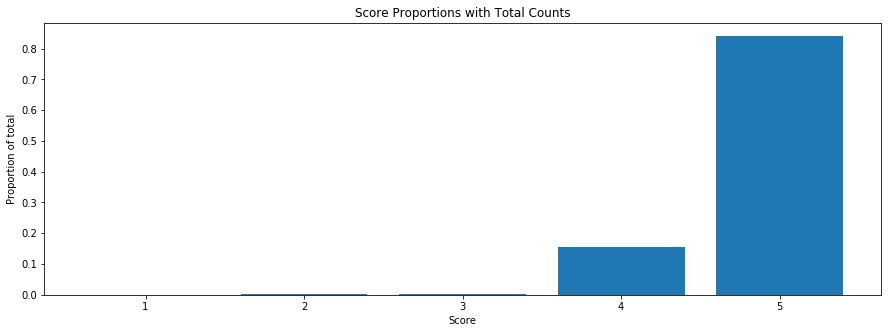

In [260]:
plt.figure(figsize=(15,5))
plt.bar(listings_distribution.index,listings_distribution.values)
plt.title('Score Proportions with Total Counts')
plt.xlabel('Score')
plt.ylabel('Proportion of total')

In [261]:
reviews = pd.read_pickle('~/Notebooks/data/reviews.pickle').drop_duplicates()
reviews = reviews[(~reviews['comments'].isna())]
listings = pd.read_pickle('~/Notebooks/data/listings.pickle')
# index_mask = listings['summary'].dropna().index.groupby('id')
listings = listings.loc[index_mask][listings['country_code']=='US'].drop_duplicates()
unique_listings = listings.groupby('id')[['review_scores_rating']].agg('min').dropna().sample(frac=(1/8),random_state=3)
unique_listings['score'] = unique_listings['review_scores_rating'].div(20).round().replace(0,1)

In [262]:
reviews = reviews.set_index('listing_id').loc[unique_listings.index.unique()]
num_reviews = reviews.shape[0]
small_mask = np.zeros(num_reviews).astype(bool)
indices = np.arange(num_reviews)
for ident in unique_listings.index.unique():
    mask = (reviews.index==ident)
    new_index = np.random.choice(indices[mask],2)
    small_mask[new_index] = True
additional_indices = np.random.choice(indices[np.logical_not(small_mask)],30000+sum(small_mask),replace=False)


small_mask[additional_indices] = True
new_reviews = reviews.iloc[small_mask]
new_reviews.index.value_counts()
new_reviews.index.unique().shape

new_reviews = new_reviews.join(unique_listings['score'],how='inner').reset_index().set_index('id')

In [263]:
new_reviews = reviews.iloc[small_mask]
new_reviews.index.value_counts()
new_reviews.index.unique().shape

new_reviews = new_reviews.join(unique_listings['score'],how='inner').reset_index().set_index('id')

new_reviews.columns = ['listing_id', 'date', 'reviewer_id', 'reviewer_name', 'comments', 'score']
new_reviews = new_reviews.loc[~new_reviews.index.duplicated(keep='first')]

new_reviews['comments'] = [' '.join([word.lower() for word in sent.split()\
                                        if word not in punctuation]) for sent in new_reviews['comments']]

hotel_X = hotel_text[['reviews.text']]
hotel_X['train_test'] = 'Train'
hotel_X.columns = ['review','train_test']
abnb_X = new_reviews[['comments']]
abnb_X['train_test']= 'Test'
abnb_X.columns = ['review','train_test']
df_X = pd.concat([abnb_X,hotel_X],axis=0,ignore_index=False).reset_index()

df_X[df_X['train_test']=='Train'].index



Int64Index([33784, 33785, 33786, 33787, 33788, 33789, 33790, 33791, 33792,
            33793,
            ...
            66062, 66063, 66064, 66065, 66066, 66067, 66068, 66069, 66070,
            66071],
           dtype='int64', length=32288)

In [264]:
X = df_X['review']
y = hotel_text['reviews.rating'].replace(1,2)
count = CountVectorizer(stop_words=sws,ngram_range=(1,1))
tfidf = TfidfVectorizer(stop_words=sws)
X = count.fit_transform(X).toarray()[df_X[df_X['train_test']=='Train'].index]

## Winning Model w/ Extended BOW feature set

In [283]:
import tensorflow
# keras = tf.keras
# from scipy import stats
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split

# %matplotlib inline


# model = keras.Sequential()
# model.add(keras.layers.SimpleRNN(32, input_shape=(n_prev, 1), return_sequences=True))
# model.add(keras.layers.SimpleRNN(32, return_sequences=False))
# model.add(keras.layers.Dense(1, activation='linear'))
# model.compile(optimizer='rmsprop',
#               loss='mse')

ModuleNotFoundError: No module named 'tensorflow'

Training Accuracy 0.68
mnb Accuracy 0.582
mnb Distribution Accuracy 0.86
mnb Error Accuracy 0.904


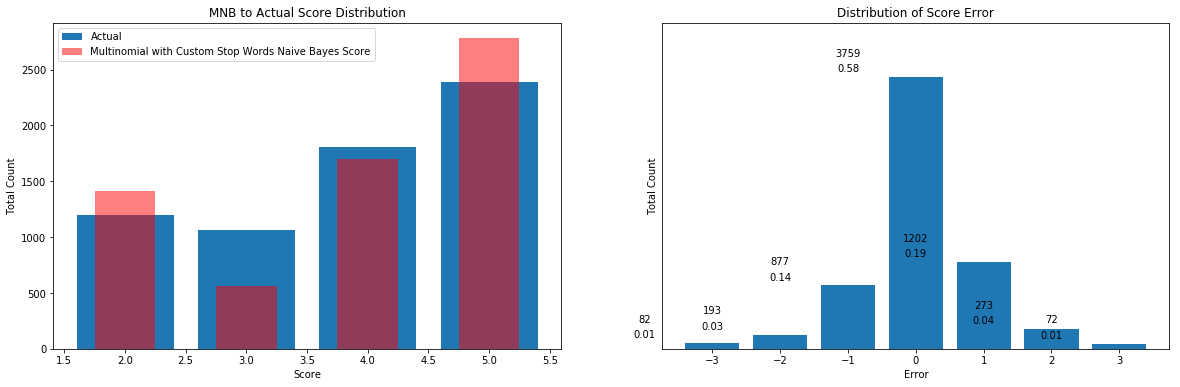

In [268]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()



X = df_X['review']
y = hotel_text['reviews.rating']
count = CountVectorizer(stop_words=sws,ngram_range=(1,1))
tfidf = TfidfVectorizer(stop_words=sws)
X = count.fit_transform(X).toarray()[df_X[df_X['train_test']=='Train'].index]
x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=3,stratify=y,test_size=.20)

nb.fit(x_train,y_train)
ypred = pd.Series(nb.predict(x_test),index=y_test.index)
ypred_train = nb.predict(x_train)
# print('Test: ',(ypred - y_test).value_counts().max()/(ypred - y_test).value_counts().sum())
# print('Train: ',(ypred_test - y_train).value_counts().max()/(ypred_test - y_train).value_counts().sum())
mnb_plots = model_plots()


mnb_plots.model_to_actual_plot(hotel_text,
                              y_test,
                              ypred,
                              'Actual',
                              'Multinomial with Custom Stop Words Naive Bayes Score',
                              'MNB to Actual Score Distribution')
mnb_plots.error_plot(hotel_text,ypred,y_test,'Error','total count')

accuracy_mnb = (ypred == y_test).mean().round(3)
distribution_error_mnb = (ypred.sub(y_test).abs().sum()/y_test.sum()).round(3)
error_accuracy_mnb = ((y_test.sub(ypred)).lt(2) & (y_test.sub(ypred)).gt(-2)).mean().round(3)
training_accuracy_mnb = round((ypred_train - y_train).value_counts().max()/(ypred_train - y_train).value_counts().sum(),2)

print('Training Accuracy',training_accuracy_mnb)
print('mnb Accuracy',accuracy_mnb)
print('mnb Distribution Accuracy',1-distribution_error_mnb)
print('mnb Error Accuracy',error_accuracy_mnb.round(3))

# 7.Final_Outcome
0. | [Top](#0.Intro)


- Methodology: Select sample of 1000 homes across Portland. Add aggregated home level score to each of the ~ 35000 airbnb reviews. Apply same feature engineering to test reviews and predict using model
- Outcome: Surprisingly the model predicts high using all metrics with an accuracy of 83%, a much higher score than was achieved on test dataset. This leaves a seemingly clear outcome for Capstone 2: Namely that there does not to be variance between sentiment left in reviews and scores. It does not per se suggest that there is no bias, but that the experience is a different one, and given the experience, expectations change
- Takeaways: 
    1. EDA is difficult without the right tools. Uncovered issues with the actual data used for analysis in capstone 2 that I didn't manage to identify in cap1. 
        - Automated Messages
        - Incorrectly labeled reviews
        - straight up noise: reviews that should not at all count as a review of any kind
        - languages
    2. Continue to modulate code - helps to stay organized
    3. That abnb reviews are as biased as scores
- Next Steps:
    1. Continue: 1. More data (it's clear that accuracy increases as addition data gets added): Hypothesis Test 
    2. ?? New Capstone?

In [71]:
np.random.seed(10)
np.random.randint(10,size=(10,10))#[[1,2,3]]

array([[9, 4, 0, 1, 9, 0, 1, 8, 9, 0],
       [8, 6, 4, 3, 0, 4, 6, 8, 1, 8],
       [4, 1, 3, 6, 5, 3, 9, 6, 9, 1],
       [9, 4, 2, 6, 7, 8, 8, 9, 2, 0],
       [6, 7, 8, 1, 7, 1, 4, 0, 8, 5],
       [4, 7, 8, 8, 2, 6, 2, 8, 8, 6],
       [6, 5, 6, 0, 0, 6, 9, 1, 8, 9],
       [1, 2, 8, 9, 9, 5, 0, 2, 7, 3],
       [0, 4, 2, 0, 3, 3, 1, 2, 5, 9],
       [0, 1, 0, 1, 9, 0, 9, 2, 1, 1]])

Final Accuracy 0.829
Final Distribution Accuracy 0.958
Final Error Accuracy 0.975


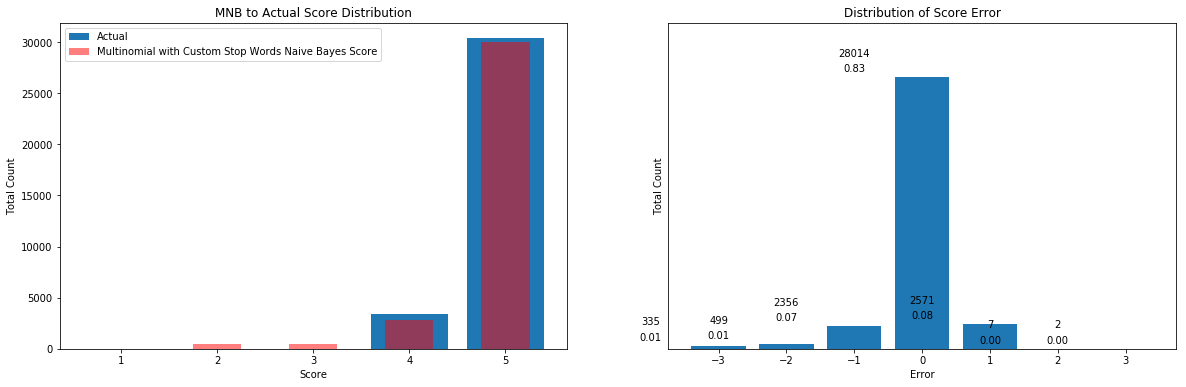

In [269]:
X = df_X['review']
count = CountVectorizer(stop_words=sws,ngram_range=(1,1))
tfidf = TfidfVectorizer(stop_words=sws)
X = count.fit_transform(X).toarray()[df_X[df_X['train_test']=='Test'].index]


ypred = pd.Series(nb.predict(X),index=new_reviews.index)
# print('Test: ',(ypred - y_test).value_counts().max()/(ypred - y_test).value_counts().sum())
# print('Train: ',(ypred_test - y_train).value_counts().max()/(ypred_test - y_train).value_counts().sum())
final_plots = model_plots()


final_plots.model_to_actual_plot(new_reviews,
                              new_reviews['score'],
                              ypred,
                              'Actual',
                              'Multinomial with Custom Stop Words Naive Bayes Score',
                              'MNB to Actual Score Distribution')
final_plots.error_plot(new_reviews,ypred,new_reviews['score'],'Error','total count')

accuracy_final = (ypred == new_reviews['score']).mean().round(3)
distribution_error_final = (ypred.sub(new_reviews['score']).abs().sum()/new_reviews['score'].sum()).round(3)
error_accuracy_final = ((new_reviews['score'].sub(ypred)).lt(2) & (new_reviews['score'].sub(ypred)).gt(-2)).mean().round(3)


print('Final Accuracy',accuracy_final)
print('Final Distribution Accuracy',1-distribution_error_final)
print('Final Error Accuracy',error_accuracy_final.round(3))

In [170]:
# new_reviews['prediction'] = ypred
# new_reviews[((ypred-new_reviews['score']!= 0) & (ypred<4))]

In [185]:
balance_reviews = pd.read_pickle('data/balanced_reviews.pickle')

abnb_X2 = balance_reviews[['comments','review_scores_rating']]
abnb_X2['train_test']= 'Test'
abnb_X2.columns = ['review','review_scores_rating','train_test']

df_X2 = pd.concat([abnb_X2,hotel_X],axis=0,ignore_index=False).reset_index()

# df_X[df_X['train_test']=='Train'].index
X = df_X2[['review']]
y = hotel_text['reviews.rating']
count = CountVectorizer(stop_words=sws,ngram_range=(1,1))
tfidf = TfidfVectorizer(stop_words=sws)
X = count.fit_transform(X['review']).toarray()[df_X2[df_X2['train_test']=='Train'].index]

In [186]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=3,stratify=y,test_size=.20)

nb.fit(x_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [187]:
abnb_X2 = balance_reviews[['comments','review_scores_rating']]
abnb_X2['train_test']= 'Test'
abnb_X2.columns = ['review','review_scores_rating','train_test']

df_X2 = pd.concat([abnb_X2,hotel_X],axis=0,ignore_index=False).reset_index()

Final Accuracy 0.32
Final Distribution Accuracy 0.663
Final Error Accuracy 0.646


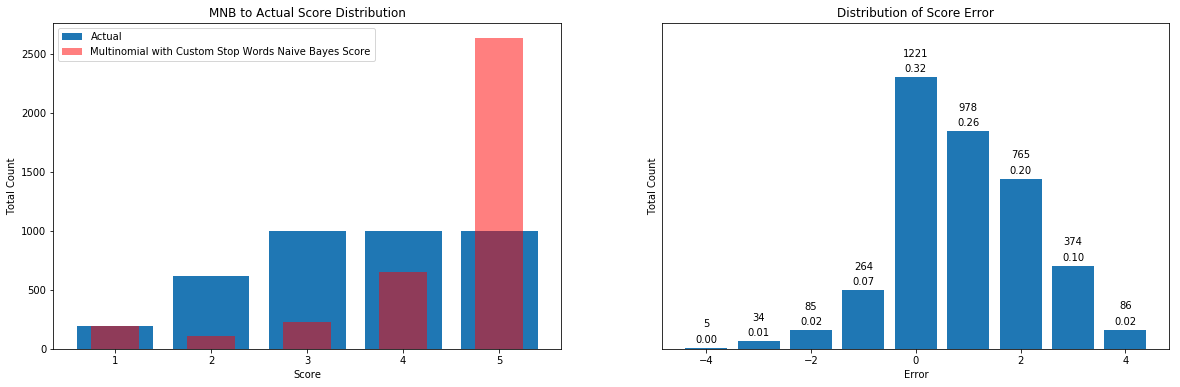

In [217]:
X = df_X2[['review','review_scores_rating']]
count = CountVectorizer(stop_words=sws,ngram_range=(1,1))
tfidf = TfidfVectorizer(stop_words=sws)
X = count.fit_transform(X['review']).toarray()[df_X2[df_X2['train_test']=='Test'].index]


ypred = pd.DataFrame(nb.predict(X),index=balance_reviews.index,columns=['prediction'])
ypred_series = pd.Series(nb.predict(X),index=balance_reviews.index)
x = df_X2[df_X2['train_test']=='Test'].set_index('index').join(ypred)


# print('Test: ',(ypred - y_test).value_counts().max()/(ypred - y_test).value_counts().sum())
# print('Train: ',(ypred_test - y_train).value_counts().max()/(ypred_test - y_train).value_counts().sum())
final_plots = model_plots()


final_plots.model_to_actual_plot(balance_reviews,
                              balance_reviews['score'],
                              ypred_series,
                              'Actual',
                              'Multinomial with Custom Stop Words Naive Bayes Score',
                              'MNB to Actual Score Distribution')
final_plots.error_plot(balance_reviews,ypred_series,balance_reviews['score'],'Error','total count')

accuracy_final = (ypred_series == balance_reviews['score']).mean().round(3)
distribution_error_final = (ypred_series.sub(balance_reviews['score']).abs().sum()/balance_reviews['score'].sum()).round(3)
error_accuracy_final = ((balance_reviews['score'].sub(ypred_series)).lt(2) & (balance_reviews['score'].sub(ypred_series)).gt(-2)).mean().round(3)


print('Final Accuracy',accuracy_final)
print('Final Distribution Accuracy',1-distribution_error_final)
print('Final Error Accuracy',error_accuracy_final.round(3))

In [153]:
x.set_index('index').join(ypred).index.shape[0]
x.set_index('index').join(ypred).index.unique().shape[0]


3812

In [218]:
x

,review,review_scores_rating,train_test,prediction
index,,,,
1448,"I am not upset that Eleza had to cancel my reservation due to pluming problems at her home. I find it unacceptable that she didn't bother to tell me until 1pm the day I was supposed to check in, ...",20.0,Test,1
1449,Do not reserve a room at this residence! The house is in disrepair the property is not appealing. There are extensive pet odors in the house and is very unclean in the living spaces and the bathro...,20.0,Test,2
1450,"My employees had a great stay at Eleza's place! Very clean and accommodating, Eleza was a great host. Definitely consider this place for your next trip to PDX!",20.0,Test,5
1451,This is a great old house. Very large and you can feel the history that lives in the walls. Our host was very responsive in helping fix problems we had. It’s a great space and easy commute to the ...,20.0,Test,5
1964,"What to say... The only good think is the location... All the rest is just hell...\nIf you have choice, even for the price, don't rent there...",20.0,Test,3
2464,"I definitely would not recommend staying with Kevin or his place at all. Although a likable guy, he was completely unprepared to have guests in an Airbnb arrangement. The mattress was turned on it...",20.0,Test,1
3100,"The host was responsive. The location is conveninent as it is close to many things if you don't mind loud traffic noice. Apart from the bed room, other areas of the apartment are quite dirty. The ...",20.0,Test,3
3381,More than likely Monica has never stayed at an Airbnb. She said the checkin time was flexible and we could get into our room by noon. We walked around Portland until 2:45 with our luggage. There w...,20.0,Test,2
4261,"First of all, Joe and Linda were very nice to us. I'm sorry to report though, we were very disappointed in the accommodations. The picture you see is of their living room, NOT, where we stayed. ...",20.0,Test,1
